In [79]:
import numpy as np
import pandas as pd
cancer = pd.read_csv('cancer.csv')
spam = pd.read_csv('spam.csv')

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

def split_features_and_labels(df):
    features = MinMaxScaler().fit_transform(df.drop('label', axis=1))
    labels = LabelEncoder().fit_transform(df['label'])
    return features, labels

In [17]:
spam_features, spam_labels = split_features_and_labels(spam)
cancer_features, cancer_labels = split_features_and_labels(cancer)

c:\users\olga\appdata\local\programs\python\python36\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [22]:
from sklearn.model_selection import train_test_split

cancer_X_train, cancer_X_test, cancer_y_train, cancer_y_test = train_test_split(cancer_features, cancer_labels, test_size=0.2)
spam_X_train, spam_X_test, spam_y_train, spam_y_test = train_test_split(spam_features, spam_labels, test_size=0.2)

In [71]:
from collections import Counter
import sklearn.metrics 
class Node:
    feature = None
    threshold = None
    left, right = None, None
    answer = None
    
    def __init__(self, samples, labels, depth):
        self.samples = samples
        self.labels = labels
        self.size = len(labels)
        self.depth = depth
    
    def gini(self, labels):
        if len(labels) == 0:
            return float('inf')
        counter = Counter(labels)
        return counter[1] * counter[0] / len(labels) ** 2
    
    def split(self, max_depth=10):
        if self.depth == max_depth:
            self.answer = np.count_nonzero(np.logical_not(self.labels)) / self.size, np.count_nonzero(self.labels) / self.size
            return
        
        max_gain = 0
        best_feature = None
        best_threshold = None
        left, right = None, None
        
        for f in range(self.samples.shape[1]):
            cur_f = self.samples[:, f]
            for threshold in np.unique(cur_f):
                hypothesis = cur_f <= threshold
                labels1 = self.labels[hypothesis]
                labels2 = self.labels[np.logical_not(hypothesis)]
                cur_gini = calc_gini(self.labels)
                
                inf_gain = self.size * cur_gini - labels1.shape[0] * calc_gini(labels1) - labels2.shape[0] * calc_gini(labels2)
                if inf_gain > max_gain and labels1.shape[0] and labels2.shape[0]:
                    
                    max_gain = inf_gain
                    best_feature = f
                    best_threshold = threshold
                    left, right = hypothesis, np.logical_not(hypothesis)
        if best_feature is None:
            self.answer = np.count_nonzero(np.logical_not(self.labels)) / self.size, np.count_nonzero(self.labels) / self.size
            return
        
        left = Node(self.samples[left], self.labels[left], self.depth + 1)
        right = Node(self.samples[right], self.labels[right], self.depth + 1)
        self.feature = best_feature
        self.threshold = best_threshold
        self.left, self.right = left, right
        left.split(max_depth)
        right.split(max_depth)
        
    def get_proba(self, X_test):
        res = []
        for point in X_test:
            cur_node = self
            while cur_node.answer == None:
                if point[cur_node.feature] <= cur_node.threshold:
                    cur_node = cur_node.left
                else:
                    cur_node = cur_node.right
            res.append(cur_node.answer[0])
        return res

    def predict(self, X_test):
        return list(map(lambda x : 0 if np.random.uniform() < x else 1, self.get_proba(X_test)))
        
    def accuracy_score(self, X, y_true):
        y_pred = self.predict(X)
        return sklearn.metrics.accuracy_score(y_true, y_pred)
                
        
def build_tree(data, labels, max_depth=10):
    root = Node(data, labels, 0)
    root.split(max_depth)
    return root



In [73]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

def draw_roc_curve(y_true, probs):
    frp, tpr, _ = roc_curve(y_true, probs)
    plt.plot(tpr.tolist(), frp.tolist())

In [76]:
def best_depth(X_train, y_train, X_test, y_test):
    best_tree, best_acc = None, None
    for depth in range(1, 11):
        tree = build_tree(X_train, y_train, depth)
        acc = tree.accuracy_score(X_test, y_test)
        print(f'Accuracy for depth {depth} is {acc}')
        if best_acc is None or best_acc < acc:
            best_acc = acc
            best_tree = tree
    draw_roc_curve(y_test, best_tree.get_proba(X_test))

Accuracy for depth 1 is 0.8421052631578947
Accuracy for depth 2 is 0.8947368421052632
Accuracy for depth 3 is 0.9122807017543859
Accuracy for depth 4 is 0.9122807017543859
Accuracy for depth 5 is 0.9473684210526315
Accuracy for depth 6 is 0.9385964912280702
Accuracy for depth 7 is 0.9385964912280702
Accuracy for depth 8 is 0.9298245614035088
Accuracy for depth 9 is 0.9298245614035088
Accuracy for depth 10 is 0.9298245614035088


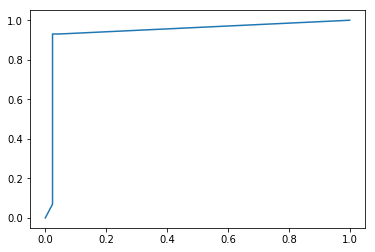

In [77]:
best_depth(cancer_X_train, cancer_y_train, cancer_X_test, cancer_y_test)

Accuracy for depth 1 is 0.6905537459283387
Accuracy for depth 2 is 0.7893593919652552
Accuracy for depth 3 is 0.8078175895765473
Accuracy for depth 4 is 0.8555917480998915
Accuracy for depth 5 is 0.8588490770901195
Accuracy for depth 6 is 0.8610206297502715
Accuracy for depth 7 is 0.8762214983713354
Accuracy for depth 8 is 0.8925081433224755
Accuracy for depth 9 is 0.9011943539630836
Accuracy for depth 10 is 0.8881650380021715


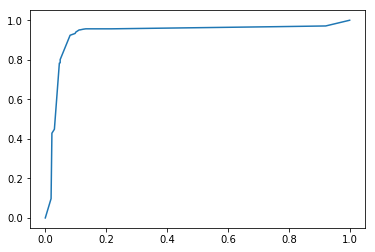

In [78]:
best_depth(spam_X_train, spam_y_train, spam_X_test, spam_y_test)